In [1]:
from client.model import compile_model, save_parameters
from client.data import load_data
from server_functions import ServerFunctions
from scaleout.client.edge_client import EdgeClient
import torch
import matplotlib.pyplot as plt
import numpy as np
import client
import client.startup
import importlib

importlib.reload(client.startup)
importlib.reload(client)


model = compile_model()
print(model)

N_clients = 2
edge = EdgeClient()
clients = [client.startup.MyClient(edge) for _ in range(N_clients)]

2026-02-17 09:47:51 [DEBUG] Token cache initialized at: C:\Users\maxha\.scaleout\tokens\api-client.json
Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


klar inläsning


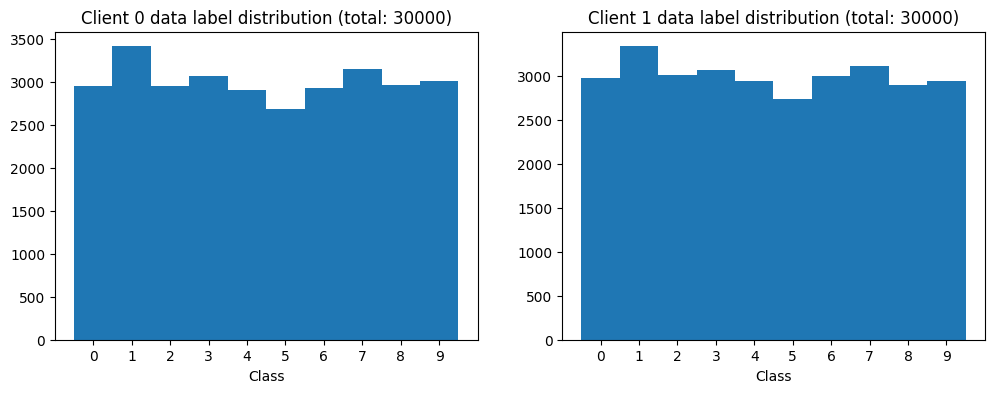

In [12]:
import pickle
import torchvision
from torchvision import transforms, datasets
def niid_loader(data_path=None, dataset_name='mnist', is_train=True, download=False):
    """Implements non-iid data across clients using NIID-bench: 
    https://github.com/Xtra-Computing/NIID-Bench#"""

    
    if data_path == None:
        print('No data path given!')
        return
        
    
    #Imagenette för convnext
    if dataset_name == 'imagenette':
        data = load_data(data_path=data_path, is_train=is_train, download=download)
        print(data)
        print(data[0][0].shape)

        #non-iid map
        with open('./max_dataidx_maps/imagenette_500samples_dataidx_map_labeldir_beta05.pkl', 'rb') as f:
            idx_dict = pickle.load(f)


        with open('./max_dataidx_maps/imagenette_indices.pkl', 'rb') as f:
            indices_map = pickle.load(f)    #Mappar subset-idx till riktiga idx i datasetet


        client_ds = [
            torch.utils.data.Subset(data, indices_map[indices])
            for key, indices in idx_dict.items()
            ]
        
            
    #MNIST
    elif dataset_name == 'mnist':
        data = datasets.MNIST(
            root=data_path, 
            train=is_train,
            download=download,
            transform=transforms.Compose([
                transforms.ToTensor()
            ])
        )

        #non-iid map
        with open('./max_dataidx_maps/net_dataidx_map_labeldir_beta05.pkl', 'rb') as f:
            idx_dict = pickle.load(f)

        client_ds = [
            torch.utils.data.Subset(data, indices)
            for key, indices in idx_dict.items()
            ]
   

    return client_ds

# #IID
data = datasets.MNIST(
            root='./max_data', 
            train=True,
            download=False,
            transform=transforms.Compose([
                transforms.ToTensor()
            ])
        )
client_ds = torch.utils.data.random_split(data, [0.5, 0.5])


# client_ds = niid_loader(
#     data_path='./max_data', 
#     is_train=True, 
#     dataset_name='mnist',
#     )


print('klar inläsning')
labels = [[] for _ in range(N_clients)]
for c in range(N_clients):
    for _, label in client_ds[c]:
        labels[c].append(label)

#Client data distribution
fig, axs = plt.subplots(1,N_clients, figsize=(12,4))
for i, client_labels in enumerate(labels):
    axs[i].hist(client_labels, bins=np.arange(11)-0.5)
    axs[i].set_title(f'Client {i} data label distribution (total: {len(client_labels)})')
    axs[i].set_xlabel('Class')
    axs[i].set_xticks(np.arange(10))
plt.show()

In [3]:
from torch.utils.data import DataLoader, TensorDataset

def dataset_to_tensor(dataset, batch_size=256, num_workers=0):
    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers)

    xs = []
    ys = []

    for x, y in loader:
        xs.append(x)
        ys.append(y)

    X = torch.cat(xs)
    Y = torch.cat(ys)

    return TensorDataset(X, Y)


In [13]:
from copy import deepcopy
from scaleoututil.serverfunctions.serverfunctionsbase import RoundType
from scaleoututil.utils.model import ScaleoutModel
from collections import defaultdict



#initialize global params
global_params = save_parameters(model)

client_ids = [i for i in range(N_clients)]
server_functions = ServerFunctions()

ram_datasets = [dataset_to_tensor(ds, batch_size=32) for ds in client_ds]
#Dataloaders
client_dl = [torch.utils.data.DataLoader(
    dataset=ds,
    batch_size=32,
    ) 
    for ds in ram_datasets
    ]

metrics_list = defaultdict(lambda: defaultdict(list))


#for .. (this is one FL round)
for round in range(10):
    selected = server_functions.client_selection(client_ids, RoundType.TRAINING) 
    settings = server_functions.client_settings(global_params) #Transform to list

    params_list = dict()
    losses = []
    for id in selected:
        #Olika datapartitioner på olika clients
        params, metadata, metrics = clients[id].train(
            scaleout_model=global_params, 
            settings=settings,
            data_loader = client_dl[id]
            )
        params_list[id] =(params.get_model_params(), metadata)
        
        for key, value in metrics.items():
            metrics_list[id][key].append(value)

        # metrics_list[id]['training_loss'].append(metrics['training_loss'])
        # metrics_list[id]['training_accuracy'].append(metrics['training_accuracy'])
        # metrics_list[id]['norm'].append(metrics['norm'])

    #Aggregate
    new_params = server_functions.aggregate(global_params.get_model_params(), params_list)
    global_params = global_params.from_model_params(new_params)



Epoch 0/0 | Batch 0/937 | Loss: 2.3243
Epoch 0/0 | Batch 100/937 | Loss: 2.3392
Epoch 0/0 | Batch 200/937 | Loss: 2.2608
Epoch 0/0 | Batch 300/937 | Loss: 2.2228
Epoch 0/0 | Batch 400/937 | Loss: 2.1797
Epoch 0/0 | Batch 500/937 | Loss: 2.0412
Epoch 0/0 | Batch 600/937 | Loss: 1.8792
Epoch 0/0 | Batch 700/937 | Loss: 1.7953
Epoch 0/0 | Batch 800/937 | Loss: 1.5584
Epoch 0/0 | Batch 900/937 | Loss: 1.2879
2026-02-17 11:34:04 [ERROR] Missing context for logging metric.
Epoch 0 finished | Loss: 1.9713 | Acc: 0.3741
Epoch 0/0 | Batch 0/937 | Loss: 2.3146
Epoch 0/0 | Batch 100/937 | Loss: 2.2705
Epoch 0/0 | Batch 200/937 | Loss: 2.2680
Epoch 0/0 | Batch 300/937 | Loss: 2.2124
Epoch 0/0 | Batch 400/937 | Loss: 2.2169
Epoch 0/0 | Batch 500/937 | Loss: 2.0632
Epoch 0/0 | Batch 600/937 | Loss: 1.8978
Epoch 0/0 | Batch 700/937 | Loss: 1.8226
Epoch 0/0 | Batch 800/937 | Loss: 1.3676
Epoch 0/0 | Batch 900/937 | Loss: 1.2854
2026-02-17 11:34:10 [ERROR] Missing context for logging metric.
Epoch 0 fi

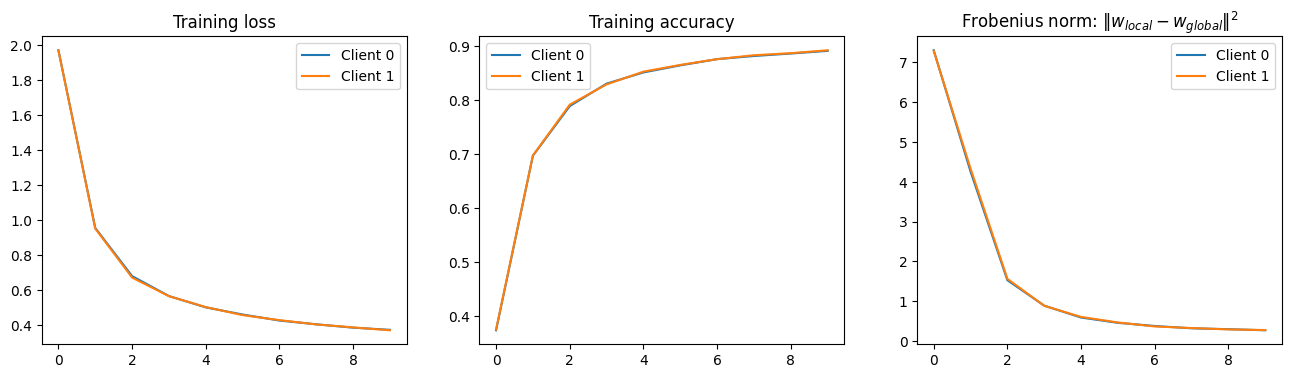

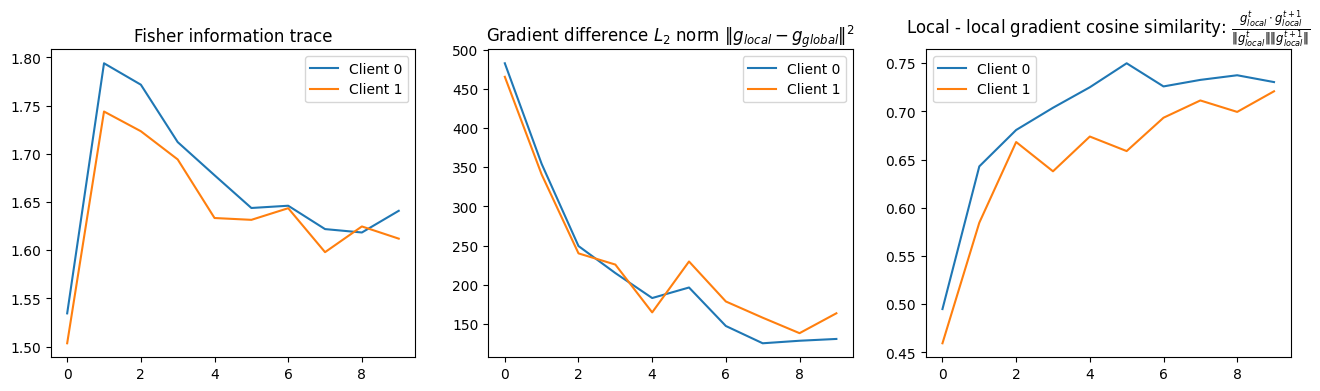

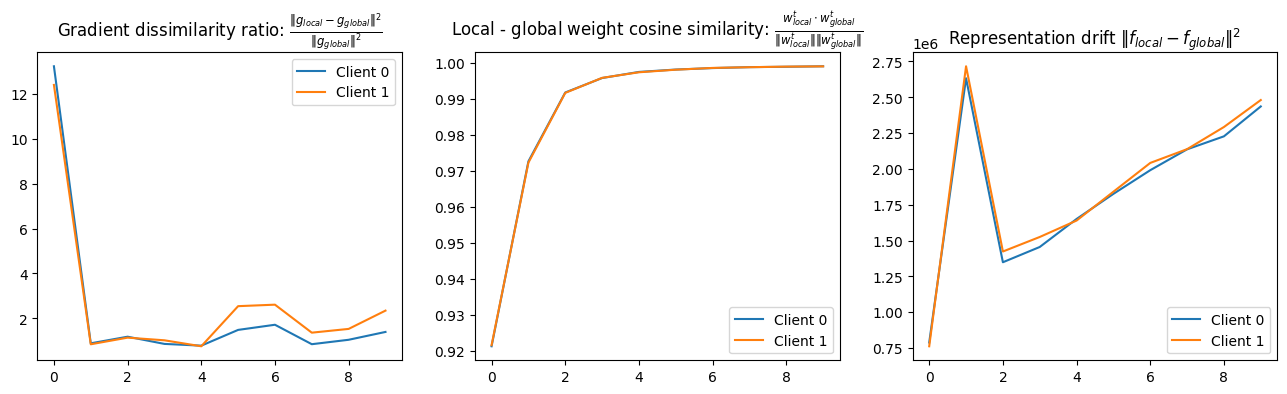

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4))
fig, (ax4, ax5, ax6) = plt.subplots(1,3, figsize=(16,4))
fix, (ax7, ax8, ax9) = plt.subplots(1,3, figsize=(16,4))

def fisher_trace(fisher_dict):
    total = 0.0
    for v in fisher_dict.values():
        total += v.sum().item()
    return total

import torch.nn.functional as F


for id in client_ids:
    ax1.plot(metrics_list[id]['training_loss'], label=f'Client {id}')
    ax2.plot(metrics_list[id]['training_accuracy'], label=f'Client {id}')
    ax3.plot(metrics_list[id]['norm'], label=f'Client {id}')

    trace = [fisher_trace(d) for d in metrics_list[id]['fisher']]
    ax4.plot(trace, label=f'Client {id}')


    g_global = torch.stack(metrics_list[id]['global_grad'], dim=1)
    g_local = torch.stack(metrics_list[id]['local_grad'], dim=1)

    norm = torch.linalg.vector_norm(g_local - g_global, dim=0)
    ax5.plot(norm, label=f'Client {id}')


    cos_sim = F.cosine_similarity(g_local[:-1], g_local[1:], dim=0)
    ax6.plot(cos_sim, label=f'Client {id}')

    dissim = torch.norm(g_local - g_global, dim=0)**2 / (
    torch.norm(g_global, dim=0)**2 + 1e-12)
    ax7.plot(dissim, label=f'Client {id}')

    ax8.plot(metrics_list[id]['weight_cosine_sim'], label=f'Client {id}')

    ax9.plot(metrics_list[id]['feature_drift'], label=f'Client {id}')





ax1.legend()
ax1.set_title('Training loss')

ax2.legend()
ax2.set_title('Training accuracy')

ax3.legend()
ax3.set_title(r'Frobenius norm: $\|w_{local} - w_{global}\|^2$')

ax4.legend()
ax4.set_title('Fisher information trace')

ax5.legend()
ax5.set_title(r'Gradient difference $L_2$ norm $\| g_{local} - g_{global}\|^2$')

ax6.legend()
ax6.set_title(r'Local - local gradient cosine similarity: $\frac{g_{local}^t \cdot g_{local}^{t+1}}{\|g_{local}^t\|\|g_{local}^{t+1}\|}$')

ax7.legend()
ax7.set_title(r'Gradient dissimilarity ratio: $\frac{\| g_{local} - g_{global} \|^2}{\|g_{global}\|^2} $')

ax8.legend()
ax8.set_title(r'Local - global weight cosine similarity: $\frac{w_{local}^t \cdot w_{global}^t}{\|w_{local}^t\|\|w_{global}^t\|}$')

ax9.legend()
ax9.set_title(r'Representation drift $\|f_{local} - f_{global}\|^2$')
plt.show()


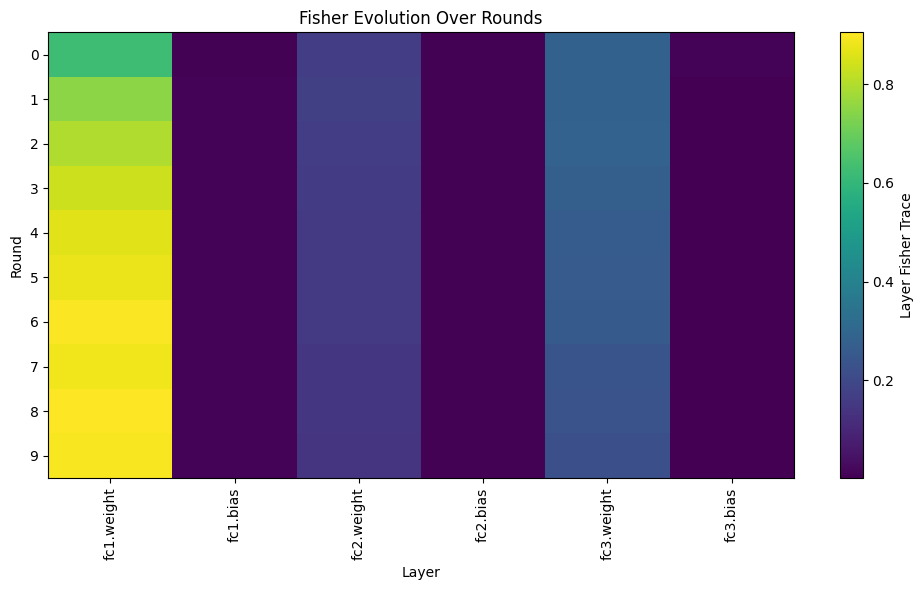

In [29]:
def fisher_layer_norms(fisher_dict):
    return {
        k: v.sum().item()
        for k, v in fisher_dict.items()
    }

# assume all clients share same layer names
layer_names = list(metrics_list[client_ids[0]]['fisher'][0].keys())
n_layers = len(layer_names)
n_rounds = 10

fisher_matrix = np.zeros((n_rounds, n_layers))

for d in range(n_rounds):
    layer_fisher = fisher_layer_norms(
        metrics_list[client_ids[0]]['fisher'][d]
    )
    fisher_matrix[d] = [layer_fisher[k] for k in layer_names]

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.imshow(fisher_matrix, aspect='auto')
plt.colorbar(label="Layer Fisher Trace")
plt.xticks(range(n_layers), layer_names, rotation=90)
plt.yticks(range(n_rounds), range(n_rounds))
plt.xlabel("Layer")
plt.ylabel("Round")
plt.title("Fisher Evolution Over Rounds")
plt.tight_layout()
plt.show()

